# INSTALACIÓN E IMPORTACIÓN DE BIBLIOTECAS Y ARCHIVOS

In [1]:
# Instalar UMAP en Google Colab (si no está instalado previamente)
!pip install umap-learn
!pip install kneed
!pip install gap-stat==2.0.2
!pip install dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [2]:
# ==== Manejo de datos ====
import pandas as pd  # Manipulación de DataFrames
import numpy as np  # Operaciones matemáticas y arrays

# ==== Métricas y clustering ====
from sklearn.metrics.pairwise import cosine_similarity  # Cálculo de similitud coseno entre vectores
from sklearn.cluster import KMeans  # Algoritmo K-Means para clustering
from sklearn.metrics import silhouette_score  # Métrica para evaluar la calidad de los clústeres
from gap_statistic import OptimalK  # Determinación del número óptimo de clústeres usando Gap Statistic

# ==== Reducción de dimensionalidad ====
import umap  # Algoritmo UMAP para reducción de dimensionalidad
from sklearn.manifold import trustworthiness  # Métrica Trustworthiness para evaluar reducción de dimensionalidad


# ==== Ploteo ====
import matplotlib.pyplot as plt  # Creación de gráficos estáticos
from matplotlib import cm  # Generación de paletas de colores para gráficos
import matplotlib.colors as mcolors  # Definición de colores personalizados en gráficos
import plotly.graph_objects as go  # Creación de gráficos interactivos con Plotly

# ==== Manejo de advertencias ====
import warnings  # Control de advertencias en el código
warnings.filterwarnings("ignore")  # Suprimir todas las advertencias


# DEFINICIÓN DE FUNCIONES

## de Procesamiento de Datos

In [3]:
def procesar_dataframe(df, fecha_min, punto_medio, fecha_max, medios_nacionales):
    """
    Procesa un DataFrame para asignar los períodos y tipos de medios según las reglas establecidas.
    """
    df['fecha'] = pd.to_datetime(df['fecha']).dt.date
    df['periodo'] = np.where(
        (df['fecha'] >= pd.to_datetime(fecha_min).date()) &
        (df['fecha'] <= pd.to_datetime(punto_medio).date()),
        f'{fecha_min} - {punto_medio}',
        f'{pd.to_datetime(punto_medio).date() + pd.Timedelta(days=1)} - {fecha_max}'
    )
    df['tipo_medio'] = df['medio'].apply(
        lambda x: 'nacional' if x in medios_nacionales else 'local'
    )
    return df


def concatenar_embeddings(row):
    """
    Concatena los embeddings de las columnas 'titulo', 'bajada' y 'cuerpo_texto' en un único vector.
    """
    embeddings = [row[columna] for columna in ['titulo', 'bajada', 'cuerpo_texto']
                  if isinstance(row[columna], np.ndarray)]
    return np.concatenate(embeddings) if embeddings else np.nan


def promediar_embeddings(row):
    """
    Promedia los embeddings de 'titulo', 'bajada' y 'cuerpo_texto' si están disponibles.
    """
    embeddings = [row[columna] for columna in ['titulo', 'bajada', 'cuerpo_texto']
                  if isinstance(row[columna], np.ndarray)]
    return np.mean(embeddings, axis=0) if embeddings else np.nan


## de Reducción de Dimensionalidad

In [4]:
def reducir_dimensionalidad(df, n_components=3, n_neighbors=20, min_dist=0.1, metric='cosine'):
    """
    Realiza la reducción de dimensionalidad utilizando UMAP sobre los embeddings de artículos y comentarios_fb.
    Si no hay comentarios, estos se mantendrán como NaN en las columnas reducidas.

    Parámetros:
    - df: DataFrame con los datos originales, que debe contener las columnas 'artículo' y 'comentarios_fb'.
    - n_components: Número de dimensiones objetivo para UMAP (2 o 3).
    - n_neighbors: Número de vecinos en UMAP.
    - min_dist: Distancia mínima para UMAP.
    - metric: Métrica para calcular la similitud.

    Retorna:
    - umap_df: DataFrame con las nuevas dimensiones UMAP separadas para 'artículo' y 'comentarios_fb'.
    - trustworthiness_articulo: Métrica de confianza de UMAP para artículos.
    - trustworthiness_comentarios: Métrica de confianza de UMAP para comentarios (None si no hay comentarios válidos).
    """

    # Procesar embeddings de artículos (todos tienen valores)
    embeddings_articulo = np.vstack(df['articulo'].values)

    # Configurar y ajustar UMAP para artículos
    umap_reducer_articulo = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        spread=1.0,
        init='spectral',
        learning_rate=1.0,
        random_state=42
    )
    umap_result_articulo = umap_reducer_articulo.fit_transform(embeddings_articulo)

    # Calcular trustworthiness para artículos
    trustworthiness_articulo = trustworthiness(embeddings_articulo, umap_result_articulo, n_neighbors=10)

    # Crear DataFrame con las dimensiones reducidas para artículos
    umap_columns_articulo = [f'UMAP_articulo{i+1}' for i in range(n_components)]
    umap_df = pd.DataFrame(umap_result_articulo, columns=umap_columns_articulo)

    # Procesar embeddings de comentarios (evitar NaN)
    comentarios_validos = df['comentarios_fb'].notna()
    embeddings_comentarios = [np.array(row['comentarios_fb']) if comentarios_validos[i] else np.full((len(df['articulo'].iloc[0]),), np.nan) for i, row in df.iterrows()]
    embeddings_comentarios = np.vstack(embeddings_comentarios)

    # Configurar y ajustar UMAP para comentarios (si hay al menos un comentario válido)
    trustworthiness_comentarios = None
    if comentarios_validos.any():
        umap_reducer_comentarios = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric,
            spread=1.0,
            init='spectral',
            learning_rate=1.0,
            random_state=42
        )
        umap_result_comentarios = umap_reducer_comentarios.fit_transform(embeddings_comentarios[comentarios_validos])

        # Calcular trustworthiness para comentarios
        trustworthiness_comentarios = trustworthiness(embeddings_comentarios[comentarios_validos], umap_result_comentarios, n_neighbors=10)

        # Crear array de NaN y colocar las filas con valores reducidos en los lugares correctos
        umap_result_comentarios_full = np.full((len(df), n_components), np.nan)
        umap_result_comentarios_full[comentarios_validos] = umap_result_comentarios
    else:
        umap_result_comentarios_full = np.full((len(df), n_components), np.nan)

    # Agregar dimensiones reducidas de comentarios al DataFrame
    umap_columns_comentarios = [f'UMAP_comentarios_fb{i+1}' for i in range(n_components)]
    umap_df_comentarios = pd.DataFrame(umap_result_comentarios_full, columns=umap_columns_comentarios)

    # Unir DataFrames
    umap_df = pd.concat([umap_df, umap_df_comentarios], axis=1)

    # Agregar datos adicionales
    umap_df['medio'] = df['medio'].values
    umap_df['fecha'] = pd.to_datetime(df['fecha']).dt.strftime('%Y-%m-%d').values
    umap_df['periodo'] = df['periodo'].values
    umap_df['url'] = df['url'].values
    umap_df['tipo_medio'] = df['tipo_medio'].values

    return umap_df, trustworthiness_articulo, trustworthiness_comentarios



## de Métricas y Clustering

In [5]:
def aplicar_kmeans(df, n_clusters, dimensions):
    """
    Aplica K-Means al DataFrame y agrega los clústeres como una nueva columna.
    """
    umap_columns = ['UMAP_articulo1', 'UMAP_articulo2'] if dimensions == 2 else ['UMAP_articulo1', 'UMAP_articulo2', 'UMAP_articulo3']
    data = df[umap_columns]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=50, init='k-means++')
    df['cluster'] = kmeans.fit_predict(data)
    return df


def calcular_inercia(data, max_clusters=30, random_state=42, n_init=10):
    """
    Calcula la inercia para diferentes números de clústeres utilizando K-Means.
    """
    inercia = []
    for k in range(1, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    return inercia


def calcular_silhouette_scores(data, n_clusters_list, random_state=42, n_init=10):
    """
    Calcula el Silhouette Score para diferentes números de clústeres.
    """
    scores = {}
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        scores[n_clusters] = score
        print(f'Silhouette Score (n = {n_clusters}): {score:.4f}')
    return scores


## de Ploteo

In [6]:
def graficar_metodo_codo(inercia, max_clusters=30):
    """
    Grafica el método del codo para determinar el número óptimo de clústeres.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters), inercia, marker='o', linestyle='-', color='b')
    plt.title('Método del Codo para Determinar Número de Clusters')
    plt.xlabel('Número de Cluster')
    plt.ylabel('Inercia')
    plt.xticks(np.arange(1, max_clusters, step=2))
    plt.grid(True)
    plt.show()


def graficar_silhouette_scores(scores):
    """
    Grafica los Silhouette Scores para diferentes números de clústeres.
    """
    n_clusters_list = list(scores.keys())
    silhouette_scores = list(scores.values())
    plt.figure(figsize=(8, 6))
    plt.plot(n_clusters_list, silhouette_scores, marker='o', linestyle='-', color='g')
    plt.title('Silhouette Score para diferentes números de clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(n_clusters_list)
    plt.grid(True)
    plt.show()

def plot_clusters(df, dimensions, title="Clustering con K-Means"):
    """
    Crea un gráfico interactivo 2D o 3D mostrando los clústeres generados.
    El gráfico es más ancho para mejorar la visualización de los datos.
    """
    import matplotlib.colors as mcolors
    from matplotlib import cm
    import plotly.graph_objects as go

    clusters = df['cluster'].unique()
    color_palette = cm.get_cmap('tab10', len(clusters))
    color_map = {cluster: mcolors.rgb2hex(color_palette(i)) for i, cluster in enumerate(clusters)}
    fig = go.Figure()

    if dimensions == 3:
        for cluster in clusters:
            df_filtered = df[df['cluster'] == cluster]
            fig.add_trace(go.Scatter3d(
                x=df_filtered['UMAP_articulo1'], y=df_filtered['UMAP_articulo2'], z=df_filtered['UMAP_articulo3'],
                mode='markers', marker=dict(size=5, color=color_map[cluster]),
                name=f"Cluster {cluster}",
                text=df_filtered.apply(lambda row: f"<b>Índice:</b> {row.name}<br>"
                                                   f"<b>Fecha:</b> {row['fecha']}<br>"
                                                   f"<b>Medio:</b> {row['medio']}<br>"
                                                   f"<b>Periodo:</b> {row['periodo']}<br>"
                                                   f"<b>URL:</b> {row['url']}<br>"
                                                   f"<b>Tipo Medio:</b> {row['tipo_medio']}<br>"
                                                   f"<b>Cluster:</b> {row['cluster']}", axis=1),
                hoverinfo='text'
            ))
        fig.update_layout(
            scene=dict(
                xaxis_title='UMAP1', yaxis_title='UMAP2', zaxis_title='UMAP3'
            ),
            title=dict(text=f"{title} (3D)", x=0.5, y=0.95, xanchor='center', yanchor='top'),
            legend=dict(x=1.02, y=0.5, xanchor='left', yanchor='middle', font=dict(size=10)),
            margin=dict(l=50, r=150, t=100, b=50),
            width=1100,  # Ancho aumentado
            height=800   # Altura reducida
        )
    elif dimensions == 2:
        for cluster in clusters:
            df_filtered = df[df['cluster'] == cluster]
            fig.add_trace(go.Scatter(
                x=df_filtered['UMAP_articulo1'], y=df_filtered['UMAP_articulo2'],
                mode='markers', marker=dict(size=5, color=color_map[cluster]),
                name=f"Cluster {cluster}",
                text=df_filtered.apply(lambda row: f"<b>Índice:</b> {row.name}<br>"
                                                   f"<b>Fecha:</b> {row['fecha']}<br>"
                                                   f"<b>Medio:</b> {row['medio']}<br>"
                                                   f"<b>Periodo:</b> {row['periodo']}<br>"
                                                   f"<b>URL:</b> {row['url']}<br>"
                                                   f"<b>Tipo Medio:</b> {row['tipo_medio']}<br>"
                                                   f"<b>Cluster:</b> {row['cluster']}", axis=1),
                hoverinfo='text'
            ))
        fig.update_layout(
            xaxis_title='UMAP1', yaxis_title='UMAP2',
            title=dict(text=f"{title} (2D)", x=0.5, y=0.95, xanchor='center', yanchor='top'),
            legend=dict(x=1.02, y=0.5, xanchor='left', yanchor='middle', font=dict(size=10)),
            margin=dict(l=50, r=150, t=100, b=50),
            width=1100,  # Ancho aumentado
            height=800,   # Altura reducida
            hovermode='closest',  # Asegura que los tooltips aparezcan correctamente
        )
    else:
        raise ValueError("Las dimensiones deben ser 2 o 3.")
    fig.show()


def plot_umap(umap_df, trustworthiness, group_by=None, dimensions=None):
    """
    Crea un gráfico interactivo (2D o 3D) utilizando los datos reducidos por UMAP.
    Se ajusta el tamaño del gráfico para que sea más ancho.
    """
    import matplotlib.colors as mcolors
    from matplotlib import cm
    import plotly.graph_objects as go

    categories = umap_df[group_by].unique()
    color_palette = cm.get_cmap('tab20', len(categories))
    color_map = {category: mcolors.rgb2hex(color_palette(i)) for i, category in enumerate(categories)}
    fig = go.Figure()

    if dimensions == 3:
        for category, color in color_map.items():
            df_filtered = umap_df[umap_df[group_by] == category]
            fig.add_trace(go.Scatter3d(
                x=df_filtered['UMAP_articulo1'], y=df_filtered['UMAP_articulo2'], z=df_filtered['UMAP_articulo3'],
                mode='markers', marker=dict(size=5, color=color),
                name=f"{group_by.capitalize()}: {category}",
                text=df_filtered.apply(lambda row: f"<b>Índice:</b> {row.name}<br>"
                                                   f"<b>Fecha:</b> {row['fecha']}<br>"
                                                   f"<b>Medio:</b> {row['medio']}<br>"
                                                   f"<b>Periodo:</b> {row['periodo']}<br>"
                                                   f"<b>URL:</b> {row['url']}<br>"
                                                   f"<b>Tipo Medio:</b> {row['tipo_medio']}<br>", axis=1),
                hoverinfo='text'
            ))
        fig.update_layout(
            scene=dict(xaxis_title='UMAP1', yaxis_title='UMAP2', zaxis_title='UMAP3'),
            title=dict(text=f"Reducción de Dimensionalidad con UMAP ({dimensions}D) | Trustworthiness: {trustworthiness:.4f} | Group by: {group_by.capitalize()}",
                       x=0.5, y=0.98, xanchor='center', yanchor='top'),
            legend=dict(x=1.02, y=0.5, xanchor='left', yanchor='middle'),
            margin=dict(l=50, r=150, t=120, b=50),
            width=1100,  # Ancho aumentado
            height=800   # Altura reducida
        )
    elif dimensions == 2:
        for category, color in color_map.items():
            df_filtered = umap_df[umap_df[group_by] == category]
            fig.add_trace(go.Scatter(
                x=df_filtered['UMAP_articulo1'], y=df_filtered['UMAP_articulo2'],
                mode='markers', marker=dict(size=5, color=color),
                name=f"{group_by.capitalize()}: {category}",
                text=df_filtered.apply(lambda row: f"<b>Índice:</b> {row.name}<br>"
                                                   f"<b>Fecha:</b> {row['fecha']}<br>"
                                                   f"<b>Medio:</b> {row['medio']}<br>"
                                                   f"<b>Periodo:</b> {row['periodo']}<br>"
                                                   f"<b>URL:</b> {row['url']}<br>"
                                                   f"<b>Tipo Medio:</b> {row['tipo_medio']}<br>", axis=1),
                hoverinfo='text'
            ))
        fig.update_layout(
            xaxis_title='UMAP1', yaxis_title='UMAP2',
            title=dict(text=f"Reducción de Dimensionalidad con UMAP ({dimensions}D) | Trustworthiness: {trustworthiness:.4f} | Group by: {group_by.capitalize()}",
                       x=0.5, y=0.98, xanchor='center', yanchor='top'),
            legend=dict(x=1.02, y=0.5, xanchor='left', yanchor='middle'),
            margin=dict(l=50, r=150, t=120, b=50),
            width=1100,  # Ancho aumentado
            height=800,   # Altura reducida
            hovermode='closest',  # Asegura que los tooltips aparezcan correctamente
        )
    else:
        raise ValueError("La función solo soporta gráficos 2D o 3D.")

    fig.show()





# Función única para asignar colores fijos a los clústeres
def asignar_colores_fijos(df, cluster_col='cluster'):
    """
    Crea un diccionario de colores fijos para cada clúster.
    Si hay más de 10 clústeres, usa la paleta tab20.
    """
    clusters_unicos = sorted(df[cluster_col].unique())  # Ordena los clusters para asignación fija
    color_palette = cm.get_cmap('tab10', len(clusters_unicos)) if len(clusters_unicos) <= 10 else cm.get_cmap('tab20', len(clusters_unicos))
    return {cluster: mcolors.rgb2hex(color_palette(i)) for i, cluster in enumerate(clusters_unicos)}

# Variables separadas para evitar conflictos entre 3D y 2D
color_map_global_3D = None
color_map_global_2D = None


def graficar_embeddings_interactivos_3D_con_clusters_y_comentarios_comunes(
    df, record_indices, cluster_col='cluster', comments_color='purple',
    line_color='lightgray', line_opacity=0.5, selected_cluster=None
):
    """
    Crea un gráfico interactivo en 3D mostrando las reducciones de embeddings de 'articulo' diferenciados por clúster,
    y los comentarios_fb en un color común, conectados con líneas translúcidas.
    """

    global color_map_global_3D  # Para asegurarnos de usar la misma asignación de colores en todas las ejecuciones

    # Si es la primera vez que se ejecuta la función, generamos el diccionario de colores
    if color_map_global_3D is None:
        color_map_global_3D = asignar_colores_fijos(df, cluster_col)

    # Filtrar solo el cluster seleccionado si se proporciona
    if selected_cluster is not None:
        df = df[df[cluster_col] == selected_cluster]
        clusters = [selected_cluster]  # Solo un clúster
    else:
        clusters = df[cluster_col].unique()  # Todos los clústeres

    fig = go.Figure()

    # Agregar puntos de 'articulo' diferenciados por clúster
    for cluster in clusters:
        cluster_data = df[df[cluster_col] == cluster]
        fig.add_trace(go.Scatter3d(
            x=cluster_data['UMAP_articulo1'],
            y=cluster_data['UMAP_articulo2'],
            z=cluster_data['UMAP_articulo3'],
            mode='markers',
            marker=dict(size=5, color=color_map_global_3D[cluster]),  # Usa el color fijo del diccionario global
            name=f"Cluster {cluster}",
            text=cluster_data.apply(lambda row: f"<b>Cluster:</b> {row[cluster_col]}<br>"
                                                f"<b>Índice:</b> {row['index_original']}<br>"
                                                f"<b>Medio:</b> {row['medio']}<br>"
                                                f"<b>Fecha:</b> {row['fecha']}<br>"
                                                f"<b>URL:</b> {row['url']}<br>", axis=1),
            hoverinfo='text',
            hoverlabel=dict(
                bgcolor="rgba(255,255,255,0.9)",
                font_size=12,
                font_color="black",
                align="left",
                namelength=-1  # No truncar nombres largos en la leyenda
            )
        ))

    # Agregar puntos de comentarios_fb con color común
    fig.add_trace(go.Scatter3d(
        x=df['UMAP_comentarios_fb1'],
        y=df['UMAP_comentarios_fb2'],
        z=df['UMAP_comentarios_fb3'],
        mode='markers',
        marker=dict(size=5, color=comments_color, symbol='diamond'),
        name='Comentarios FB',
        text=df.apply(lambda row: f"<b>Índice:</b> {row['index_original']}<br>"
                                  f"<b>Medio:</b> {row['medio']}<br>"
                                  f"<b>Fecha:</b> {row['fecha']}<br>"
                                  f"<b>URL:</b> {row['url']}<br>", axis=1),
        hoverinfo='text',
        hoverlabel=dict(
            bgcolor="rgba(255,255,255,0.9)",
            font_size=12,
            font_color="black",
            align="left",
            namelength=-1
        )
    ))

    # Agregar líneas conectando cada artículo con su comentario_fb
    for idx in record_indices:
        if idx in df.index:
            record = df.loc[idx]
            fig.add_trace(go.Scatter3d(
                x=[record['UMAP_articulo1'], record['UMAP_comentarios_fb1']],
                y=[record['UMAP_articulo2'], record['UMAP_comentarios_fb2']],
                z=[record['UMAP_articulo3'], record['UMAP_comentarios_fb3']],
                mode='lines',
                line=dict(color=line_color, dash='dot'),
                opacity=line_opacity,
                showlegend=False
            ))

    # Configurar diseño para que la leyenda sea legible
    fig.update_layout(
        title=f"Embeddings Reducidos en 3D: {'Todos los Clusters' if selected_cluster is None else f'Cluster {selected_cluster}'} y Comentarios FB",
        scene=dict(
            xaxis_title="UMAP1",
            yaxis_title="UMAP2",
            zaxis_title="UMAP3"
        ),
        legend=dict(
            x=1.1,  # Mueve la leyenda a la derecha
            y=0.5,
            xanchor='left',
            yanchor='middle',
            font=dict(size=12)  # Tamaño de la fuente en la leyenda
        ),
        margin=dict(l=100, r=300, t=120, b=100),  # Más espacio para la leyenda a la derecha
        width=1300,  # Ancho extra para que no se corte la leyenda
        height=900,
        hovermode='closest'
    )

    fig.show()


def graficar_embeddings_interactivos_2D_con_clusters_y_comentarios_comunes(
    df, record_indices, cluster_col='cluster', comments_color='purple',
    line_color='lightgray', line_opacity=0.5, selected_cluster=None
):
    """
    Crea un gráfico interactivo en 2D mostrando las reducciones de embeddings de 'articulo' diferenciados por clúster,
    y los comentarios_fb en un color común, conectados con líneas translúcidas.
    """

    global color_map_global_2D  # Permite mantener la misma asignación de colores en todas las ejecuciones

    # Si es la primera vez que se ejecuta la función, generamos el diccionario de colores
    if color_map_global_2D is None:
        color_map_global_2D = asignar_colores_fijos(df, cluster_col)

    # Filtrar solo el cluster seleccionado si se proporciona
    if selected_cluster is not None:
        df = df[df[cluster_col] == selected_cluster]
        clusters = [selected_cluster]  # Solo un clúster
    else:
        clusters = df[cluster_col].unique()  # Todos los clústeres

    fig = go.Figure()

    # Agregar puntos de 'articulo' diferenciados por clúster
    for cluster in clusters:
        cluster_data = df[df[cluster_col] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_data['UMAP_articulo1'],
            y=cluster_data['UMAP_articulo2'],
            mode='markers',
            marker=dict(size=8, color=color_map_global_2D[cluster]),  # Usa el color fijo del diccionario global
            name=f"Cluster {cluster}",
            text=cluster_data.apply(lambda row: f"<b>Cluster:</b> {row[cluster_col]}<br>"
                                                f"<b>Índice:</b> {row['index_original']}<br>"
                                                f"<b>Medio:</b> {row['medio']}<br>"
                                                f"<b>Fecha:</b> {row['fecha']}<br>"
                                                f"<b>URL:</b> {row['url']}<br>", axis=1),
            hoverinfo='text',
            hoverlabel=dict(
                bgcolor="rgba(255,255,255,0.9)",  # Fondo semitransparente para mejor lectura
                font_size=12,
                font_color="black",
                align="left",
                namelength=-1  # No truncar los nombres en la leyenda
            )
        ))

    # Agregar puntos de comentarios_fb con color común
    fig.add_trace(go.Scatter(
        x=df['UMAP_comentarios_fb1'],
        y=df['UMAP_comentarios_fb2'],
        mode='markers',
        marker=dict(size=8, color=comments_color, symbol='x'),
        name='Comentarios FB',
        text=df.apply(lambda row: f"<b>Índice:</b> {row['index_original']}<br>"
                                  f"<b>Medio:</b> {row['medio']}<br>"
                                  f"<b>Fecha:</b> {row['fecha']}<br>"
                                  f"<b>URL:</b> {row['url']}<br>", axis=1),
        hoverinfo='text',
        hoverlabel=dict(
            bgcolor="rgba(255,255,255,0.9)",
            font_size=12,
            font_color="black",
            align="left",
            namelength=-1
        )
    ))

    # Agregar líneas conectando cada artículo con su comentario_fb
    for idx in record_indices:
        if idx in df.index:
            record = df.loc[idx]
            fig.add_trace(go.Scatter(
                x=[record['UMAP_articulo1'], record['UMAP_comentarios_fb1']],
                y=[record['UMAP_articulo2'], record['UMAP_comentarios_fb2']],
                mode='lines',
                line=dict(color=line_color, dash='dot'),
                opacity=line_opacity,
                showlegend=False
            ))

    # Configurar diseño para asegurar que los tooltips sean legibles y que la leyenda no se corte
    fig.update_layout(
        title=f"Embeddings Reducidos: {'Todos los Clusters' if selected_cluster is None else f'Cluster {selected_cluster}'} y Comentarios FB",
        xaxis_title="UMAP1",
        yaxis_title="UMAP2",
        legend=dict(
            x=1.1,  # Mueve la leyenda a la derecha
            y=0.5,
            xanchor='left',
            yanchor='middle',
            font=dict(size=12)  # Tamaño de la fuente en la leyenda
        ),
        margin=dict(l=100, r=300, t=100, b=100),  # Más espacio para la leyenda a la derecha
        width=1300,  # Más ancho para evitar que la leyenda se corte
        height=900,
        hovermode='closest',  # Asegura que los tooltips aparezcan correctamente
    )

    fig.show()

# 1) ANÁLISIS EXPLORATORIO Y TRANSFORMACIÓN DEL DATASET

## a) Descargamos el archivo donde previamente convertimos los artículos en embeddings normalizados, en particular, los atributos: titulo, bajada, cuerpo_texto y comentarios_fb.





In [7]:
# Definimos la URL RAW del archivo CSV alojado en GitHub
embedding_normalizado = "https://raw.githubusercontent.com/Fran251184/pasantia_TUIA_CIM_Francisco_J._Alomar/main/dataset_embedding_normalizado.parquet"

# Cargamos el archivo CSV desde la URL en un DataFrame
df_embedding_normalizado = pd.read_parquet(embedding_normalizado)

In [8]:
# Apreciamos cómo luce el df
df_embedding_normalizado

medio                                                url       fecha  \
0      clarin  https://www.clarin.com/politica/impresionante-...  2024-03-05   
1      clarin  https://www.clarin.com/politica/ministro-segur...  2024-03-06   
2      clarin  https://www.clarin.com/sociedad/matan-chofer-r...  2024-03-06   
3      clarin  https://www.clarin.com/policiales/patricia-bul...  2024-03-07   
4      clarin  https://www.clarin.com/policiales/violencia-ro...  2024-03-07   
..        ...                                                ...         ...   
594  rosario3  https://www.rosario3.com/opinion/Milei-les-tir...  2024-03-29   
595  rosario3  https://www.rosario3.com/informaciongeneral/El...  2024-03-29   
596  rosario3  https://www.rosario3.com/informaciongeneral/Pu...  2024-03-29   
597  rosario3  https://www.rosario3.com/informaciongeneral/Pu...  2024-03-29   
598  rosario3  https://www.rosario3.com/informaciongeneral/Lo...  2024-03-28   

                                                titulo  \
0    [-0.6179429, -0.1067639, 0.7333442, -0.1593284...   
1    [-0.9224123, 0.1718365, 0.84802616, -0.1632964...   
2    [-0.106764615, -0.2490452, 0.19502103, -0.1477...   
3    [-0.2736231, -0.71666753, 0.40957236, -0.62208...   
4    [0.104786396, 0.025681138, 0.36736798, -0.4607...   
..                                                 ...   
594  [0.28458595, -0.31284833, 0.094020486, -0.0123...   
595  [-0.2562676, -0.09766519, 0.90033746, -0.48873...   
596  [0.18368638, -0.20616114, -0.32874525, -0.2170...   
597  [-0.13323325, -0.08827603, 0.15845633, 0.09435...   
598  [0.05879891, -0.32900518, 0.11278772, -0.06191...   

                                                bajada  \
0    [-0.33379787, 0.23630095, -0.0603534, -0.15711...   
1    [0.41490257, -0.044562936, 0.24389553, -0.3681...   
2    [0.0704484, -0.22383702, 0.38746524, -0.397453...   
3    [-0.23029912, 0.18798435, 0.32683647, -0.01507...   
4    [0.21460688, 0.09844947, 0.2520926, -0.3864644...   
..                                                 ...   
594  [-0.05510676, -0.24011809, 0.020127177, 0.0556...   
595  [-0.07845956, 0.07298303, 0.35657966, -0.30284...   
596  [-0.24655205, 0.12796152, 0.32438564, 0.008994...   
597  [-0.57121783, -0.4031453, 0.38653028, -0.13543...   
598  [-0.0045579076, 0.2670995, 0.4966669, -0.22554...   

                                          cuerpo_texto  \
0    [-0.43940228, -0.021045327, 0.72776794, -0.198...   
1    [-0.060630143, 0.16568255, 0.88403857, -0.0787...   
2    [-0.5207595, -0.0017897487, 0.48468256, -0.261...   
3    [-0.03656125, -0.067480326, 0.76330066, -0.035...   
4    [-0.21080923, 0.17380095, 0.90428114, -0.23325...   
..                                                 ...   
594  [-0.123471856, -0.48411614, 0.24690461, -0.060...   
595  [-0.5605184, -0.09077126, 0.7081815, -0.145975...   
596  [-0.22667938, -0.30026186, -0.07419157, -0.152...   
597  [-0.87978446, -0.2568537, 0.3622086, 0.1408535...   
598  [-0.32882923, -0.05656892, 0.29903924, 0.00312...   

                                        comentarios_fb  
0                                                 None  
1                                                 None  
2                                                 None  
3                                                 None  
4                                                 None  
..                                                 ...  
594  [0.39145696, -0.012049854, 0.3987807, 0.229963...  
595  [0.20751095, 0.1992017, 0.39948714, -0.1603363...  
596  [0.3225124, 0.14165497, 0.17284322, 0.08127212...  
597  [0.27397954, 0.15670502, 0.76938844, -0.054414...  
598  [-0.2570384, -0.01782751, 0.8932593, 0.0035674...  

[599 rows x 7 columns]

## b) Exploramos el df

In [9]:
#Aplicamos el metodo describe() para una captura global del df
df_embedding_normalizado.describe()

medio                                                url  \
count         599                                                599   
unique          6                                                599   
top     lacapital  https://www.clarin.com/politica/impresionante-...   
freq          195                                                  1   

             fecha                                             titulo  \
count          599                                                599   
unique          67                                                599   
top     2024-03-08  [-0.6179429, -0.1067639, 0.7333442, -0.1593284...   
freq            49                                                  1   

                                                   bajada  \
count                                                 599   
unique                                                599   
top     [-0.33379787, 0.23630095, -0.0603534, -0.15711...   
freq                                                    1   

                                             cuerpo_texto  \
count                                                 599   
unique                                                599   
top     [-0.43940228, -0.021045327, 0.72776794, -0.198...   
freq                                                    1   

                                           comentarios_fb  
count                                                 335  
unique                                                335  
top     [-0.5052806, 0.09338033, 0.6204624, -0.1648644...  
freq                                                    1

In [10]:
#Identificamos cada atributo (variable) del df
df_embedding_normalizado.columns

Index(['medio', 'url', 'fecha', 'titulo', 'bajada', 'cuerpo_texto',
       'comentarios_fb'],
      dtype='object')

In [11]:
#Identificamos el tipo de dato de cada columna
df_embedding_normalizado.dtypes

medio             object
url               object
fecha             object
titulo            object
bajada            object
cuerpo_texto      object
comentarios_fb    object
dtype: object

In [12]:
# Cantidad de valores faltantes.
df_embedding_normalizado.isna().sum()

medio               0
url                 0
fecha               0
titulo              0
bajada              0
cuerpo_texto        0
comentarios_fb    264
dtype: int64

In [13]:
# Obtener la longitud de los embeddings para cada columna de interés
columnas = ['titulo', 'bajada', 'cuerpo_texto', 'comentarios_fb']

# Verificar la estructura de los datos en las columnas
for col in columnas:
    sample = df_embedding_normalizado[col].dropna().iloc[0] if not df_embedding_normalizado[col].dropna().empty else None
    if isinstance(sample, (list, np.ndarray)):
        print(f"La columna '{col}' posee embeddings de dimensión: {len(sample)}")
    else:
        print(f"La columna '{col}' no contiene embeddings válidos.")


La columna 'titulo' posee embeddings de dimensión: 512
La columna 'bajada' posee embeddings de dimensión: 512
La columna 'cuerpo_texto' posee embeddings de dimensión: 512
La columna 'comentarios_fb' posee embeddings de dimensión: 512


## c) Tansformación del df para análisis de embeddings promediados de los artículos con comentarios de Facebook

In [14]:
# Copiar el DataFrame original
df_articulo_promediado_comentarios_fb = df_embedding_normalizado.copy()

# Promediar los embeddings normalizados en una nueva columna 'articulo'
df_articulo_promediado_comentarios_fb['articulo'] = df_articulo_promediado_comentarios_fb.apply(promediar_embeddings, axis=1)

# Eliminamos las columnas originales después de concatenar, ya que no las utilizaremos en esta instancia
df_articulo_promediado_comentarios_fb.drop(columns=['titulo', 'bajada', 'cuerpo_texto'], inplace=True)

In [15]:
# Definir los parámetros de fecha y medios nacionales
fecha_min = '2024-03-01'
punto_medio = '2024-04-03'
fecha_max = '2024-05-07'
medios_nacionales = ['clarin', 'infobae', 'lanacion']

# Aplicar la función al DataFrame
df_articulo_promediado_comentarios_fb = procesar_dataframe(
    df_articulo_promediado_comentarios_fb, fecha_min, punto_medio, fecha_max, medios_nacionales
)

# Verificar los cambios
print("DataFrame actualizado con los períodos y tipos de medios asignados:")
print(df_articulo_promediado_comentarios_fb[['fecha', 'periodo', 'tipo_medio']].tail())


DataFrame actualizado con los períodos y tipos de medios asignados:
          fecha                  periodo tipo_medio
594  2024-03-29  2024-03-01 - 2024-04-03      local
595  2024-03-29  2024-03-01 - 2024-04-03      local
596  2024-03-29  2024-03-01 - 2024-04-03      local
597  2024-03-29  2024-03-01 - 2024-04-03      local
598  2024-03-28  2024-03-01 - 2024-04-03      local


In [16]:
df_articulo_promediado_comentarios_fb

medio                                                url       fecha  \
0      clarin  https://www.clarin.com/politica/impresionante-...  2024-03-05   
1      clarin  https://www.clarin.com/politica/ministro-segur...  2024-03-06   
2      clarin  https://www.clarin.com/sociedad/matan-chofer-r...  2024-03-06   
3      clarin  https://www.clarin.com/policiales/patricia-bul...  2024-03-07   
4      clarin  https://www.clarin.com/policiales/violencia-ro...  2024-03-07   
..        ...                                                ...         ...   
594  rosario3  https://www.rosario3.com/opinion/Milei-les-tir...  2024-03-29   
595  rosario3  https://www.rosario3.com/informaciongeneral/El...  2024-03-29   
596  rosario3  https://www.rosario3.com/informaciongeneral/Pu...  2024-03-29   
597  rosario3  https://www.rosario3.com/informaciongeneral/Pu...  2024-03-29   
598  rosario3  https://www.rosario3.com/informaciongeneral/Lo...  2024-03-28   

                                        comentarios_fb  \
0                                                 None   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
594  [0.39145696, -0.012049854, 0.3987807, 0.229963...   
595  [0.20751095, 0.1992017, 0.39948714, -0.1603363...   
596  [0.3225124, 0.14165497, 0.17284322, 0.08127212...   
597  [0.27397954, 0.15670502, 0.76938844, -0.054414...   
598  [-0.2570384, -0.01782751, 0.8932593, 0.0035674...   

                                              articulo  \
0    [-0.46371436, 0.036163907, 0.46691957, -0.1715...   
1    [-0.18937995, 0.09765204, 0.65865344, -0.20340...   
2    [-0.18569191, -0.15822399, 0.35572293, -0.2688...   
3    [-0.18016116, -0.19872117, 0.49990317, -0.2241...   
4    [0.036194682, 0.09931052, 0.5079139, -0.360141...   
..                                                 ...   
594  [0.03533578, -0.34569418, 0.120350756, -0.0058...   
595  [-0.29841518, -0.038484473, 0.6550329, -0.3125...   
596  [-0.09651502, -0.12615383, -0.026183724, -0.12...   
597  [-0.5280785, -0.24942501, 0.3023984, 0.0332587...   
598  [-0.09152941, -0.039491534, 0.3028313, -0.0947...   

                     periodo tipo_medio  
0    2024-03-01 - 2024-04-03   nacional  
1    2024-03-01 - 2024-04-03   nacional  
2    2024-03-01 - 2024-04-03   nacional  
3    2024-03-01 - 2024-04-03   nacional  
4    2024-03-01 - 2024-04-03   nacional  
..                       ...        ...  
594  2024-03-01 - 2024-04-03      local  
595  2024-03-01 - 2024-04-03      local  
596  2024-03-01 - 2024-04-03      local  
597  2024-03-01 - 2024-04-03      local  
598  2024-03-01 - 2024-04-03      local  

[599 rows x 7 columns]

# 2) UMAP / K-means (promediado, **SIN** comentarios de Facebook)


## a) Reducción de dimensionalidad mediante UMAP. Utilización de gráficos en 3D y 2D de acuerdo a distintos atributos (medio, tipo_medio y periodo).


In [17]:
# Reducir dimensionalidad y plotear en 3D
umap_df_3D, trustworthiness_3D_articulo, trustworthiness_3D_comentarios = reducir_dimensionalidad(df_articulo_promediado_comentarios_fb, n_components=3)

# Agrupaciones para 3D
plot_umap(umap_df_3D, trustworthiness=trustworthiness_3D_articulo, group_by='medio', dimensions=3)
plot_umap(umap_df_3D, trustworthiness=trustworthiness_3D_articulo, group_by='tipo_medio', dimensions=3)
plot_umap(umap_df_3D, trustworthiness=trustworthiness_3D_articulo, group_by='periodo', dimensions=3)

# Reducir dimensionalidad y plotear en 2D
umap_df_2D, trustworthiness_2D_articulo, trustworthiness_2D_comentarios = reducir_dimensionalidad(df_articulo_promediado_comentarios_fb, n_components=2)

# Agrupaciones para 2D
plot_umap(umap_df_2D, trustworthiness=trustworthiness_2D_articulo, group_by='medio', dimensions=2)
plot_umap(umap_df_2D, trustworthiness=trustworthiness_2D_articulo, group_by='tipo_medio', dimensions=2)
plot_umap(umap_df_2D, trustworthiness=trustworthiness_2D_articulo, group_by='periodo', dimensions=2)


## b) K-means 3D promediado

In [18]:
# Seleccionar las columnas reducidas
df_umap_reducido_promediado = umap_df_3D[['UMAP_articulo1', 'UMAP_articulo2', 'UMAP_articulo3']]

# Encontrar el número óptimo de clústeres con OptimalK
optimal_k = OptimalK(n_jobs=1, n_iter=10)
n_clusters_optimo = optimal_k(df_umap_reducido_promediado, cluster_array=np.arange(2, 15))
print('Número óptimo de clústeres según OptimalK:', n_clusters_optimo)

# Aplicar K-Means con el número óptimo de clústeres
kmeans = KMeans(n_clusters=n_clusters_optimo, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(df_umap_reducido_promediado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(df_umap_reducido_promediado, cluster_labels)
print(f'Silhouette Score para n = {n_clusters_optimo}: {silhouette_avg:.4f}')


Número óptimo de clústeres según OptimalK: 14
Silhouette Score para n = 14: 0.3990


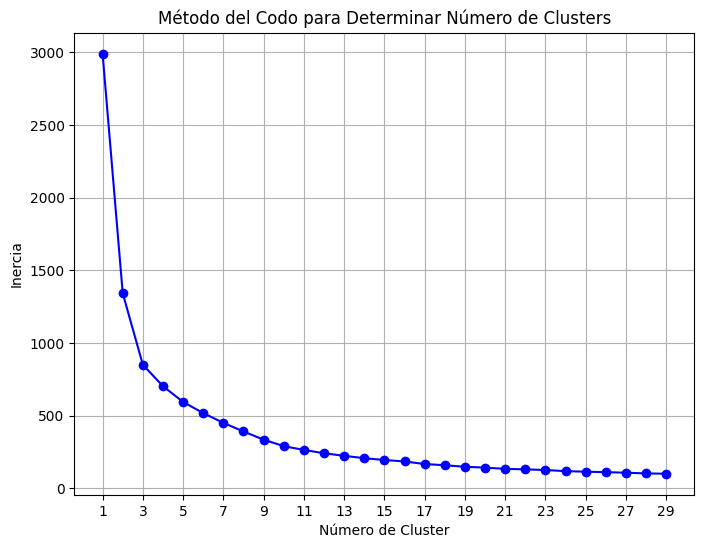

Silhouette Score (n = 2): 0.4747
Silhouette Score (n = 3): 0.4404
Silhouette Score (n = 4): 0.3729
Silhouette Score (n = 5): 0.3494
Silhouette Score (n = 6): 0.3409
Silhouette Score (n = 7): 0.3436
Silhouette Score (n = 8): 0.3585
Silhouette Score (n = 9): 0.3775
Silhouette Score (n = 10): 0.3991
Silhouette Score (n = 11): 0.4048
Silhouette Score (n = 12): 0.3975
Silhouette Score (n = 13): 0.3924
Silhouette Score (n = 14): 0.3990


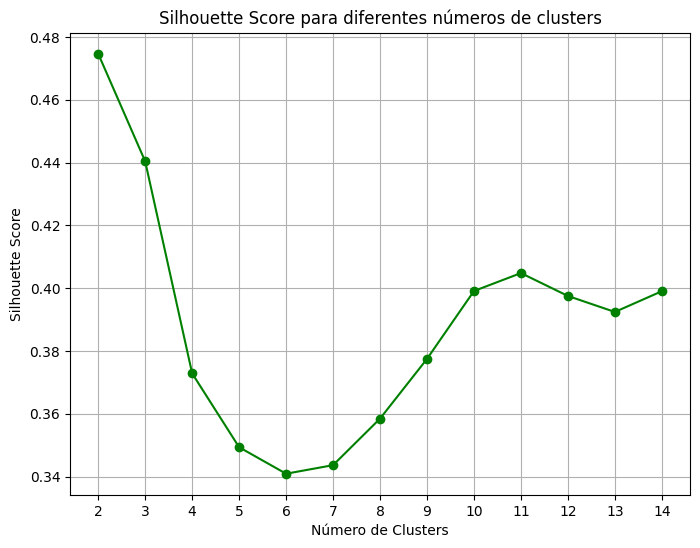

In [19]:
# Calcular la inercia para el método del codo
inercia = calcular_inercia(df_umap_reducido_promediado, max_clusters=30)

# Graficar el método del codo
graficar_metodo_codo(inercia, max_clusters=30)

# Definir el rango de clústeres para el cálculo de Silhouette Scores
n_clusters_list = range(2, 15)

# Calcular los Silhouette Scores
silhouette_scores = calcular_silhouette_scores(df_umap_reducido_promediado, n_clusters_list)

# Graficar los Silhouette Scores
graficar_silhouette_scores(silhouette_scores)

In [20]:
# Aplicar K-Means y graficar para 3D
umap_df_3D_kmeans_promediado = aplicar_kmeans(umap_df_3D, n_clusters=3, dimensions=3)
plot_clusters(umap_df_3D_kmeans_promediado, dimensions=3, title="Clustering con K-Means para datos de embeddings promediados")


In [21]:
umap_df_3D_kmeans_promediado

UMAP_articulo1  UMAP_articulo2  UMAP_articulo3  UMAP_comentarios_fb1  \
0          2.143747        4.932465        4.575902                   NaN   
1          2.045428        5.117607        4.642535                   NaN   
2          4.266856        4.965329        3.971648                   NaN   
3          1.571822        6.616514        5.364233                   NaN   
4          5.459869        5.036503        3.757568                   NaN   
..              ...             ...             ...                   ...   
594        0.896866        5.516177        3.691686              7.440098   
595        1.149383        5.420523        4.191818              8.059776   
596        3.140861        5.177135        6.791533              7.990965   
597        1.284587        5.518344        4.211517              8.525112   
598        3.309740        6.714989        3.599863              8.277479   

     UMAP_comentarios_fb2  UMAP_comentarios_fb3     medio       fecha  \
0                     NaN                   NaN    clarin  2024-03-05   
1                     NaN                   NaN    clarin  2024-03-06   
2                     NaN                   NaN    clarin  2024-03-06   
3                     NaN                   NaN    clarin  2024-03-07   
4                     NaN                   NaN    clarin  2024-03-07   
..                    ...                   ...       ...         ...   
594              2.890484              9.555129  rosario3  2024-03-29   
595              2.144280              9.871117  rosario3  2024-03-29   
596              1.429663              8.117630  rosario3  2024-03-29   
597              2.568298              9.698174  rosario3  2024-03-29   
598              2.044201              7.722419  rosario3  2024-03-28   

                     periodo  \
0    2024-03-01 - 2024-04-03   
1    2024-03-01 - 2024-04-03   
2    2024-03-01 - 2024-04-03   
3    2024-03-01 - 2024-04-03   
4    2024-03-01 - 2024-04-03   
..                       ...   
594  2024-03-01 - 2024-04-03   
595  2024-03-01 - 2024-04-03   
596  2024-03-01 - 2024-04-03   
597  2024-03-01 - 2024-04-03   
598  2024-03-01 - 2024-04-03   

                                                   url tipo_medio  cluster  
0    https://www.clarin.com/politica/impresionante-...   nacional        0  
1    https://www.clarin.com/politica/ministro-segur...   nacional        0  
2    https://www.clarin.com/sociedad/matan-chofer-r...   nacional        2  
3    https://www.clarin.com/policiales/patricia-bul...   nacional        1  
4    https://www.clarin.com/policiales/violencia-ro...   nacional        2  
..                                                 ...        ...      ...  
594  https://www.rosario3.com/opinion/Milei-les-tir...      local        1  
595  https://www.rosario3.com/informaciongeneral/El...      local        1  
596  https://www.rosario3.com/informaciongeneral/Pu...      local        0  
597  https://www.rosario3.com/informaciongeneral/Pu...      local        1  
598  https://www.rosario3.com/informaciongeneral/Lo...      local        2  

[599 rows x 12 columns]

## c) K-means 2D promediado

In [22]:
# Seleccionar las columnas reducidas
df_umap_reducido_promediado_2D = umap_df_2D[['UMAP_articulo1', 'UMAP_articulo2']]

# Encontrar el número óptimo de clústeres con OptimalK
optimal_k = OptimalK(n_jobs=1, n_iter=10)
n_clusters_optimo = optimal_k(df_umap_reducido_promediado_2D, cluster_array=np.arange(2, 15))
print('Número óptimo de clústeres según OptimalK:', n_clusters_optimo)

# Aplicar K-Means con el número óptimo de clústeres
kmeans = KMeans(n_clusters=n_clusters_optimo, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(df_umap_reducido_promediado_2D)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(df_umap_reducido_promediado_2D, cluster_labels)
print(f'Silhouette Score para n = {n_clusters_optimo}: {silhouette_avg:.4f}')

Número óptimo de clústeres según OptimalK: 14
Silhouette Score para n = 14: 0.4322


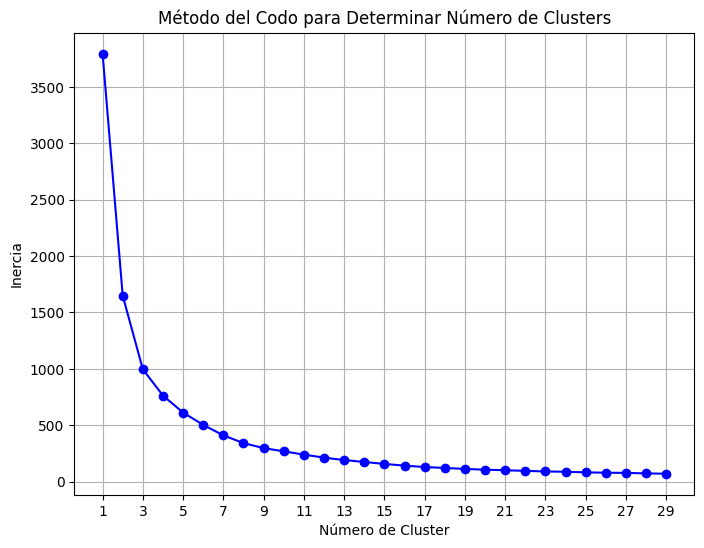

Silhouette Score (n = 2): 0.4951
Silhouette Score (n = 3): 0.4818
Silhouette Score (n = 4): 0.4191
Silhouette Score (n = 5): 0.4020
Silhouette Score (n = 6): 0.3944
Silhouette Score (n = 7): 0.4038
Silhouette Score (n = 8): 0.4176
Silhouette Score (n = 9): 0.4149
Silhouette Score (n = 10): 0.4179
Silhouette Score (n = 11): 0.4033
Silhouette Score (n = 12): 0.4198
Silhouette Score (n = 13): 0.4234
Silhouette Score (n = 14): 0.4322


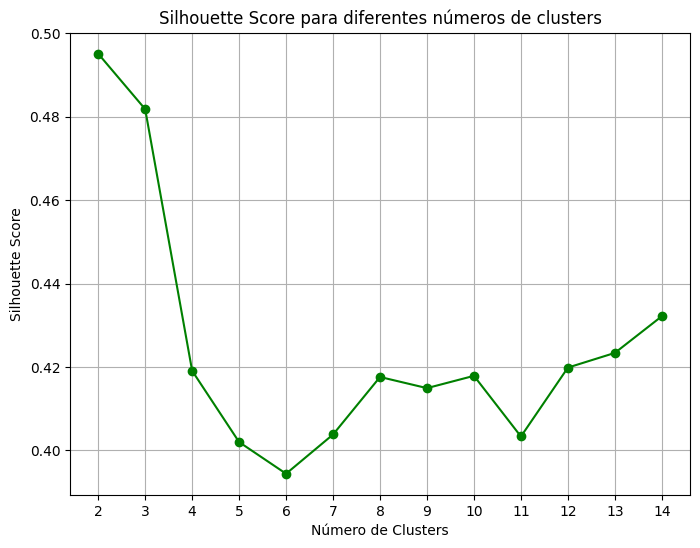

In [23]:

# Calcular la inercia para el método del codo
inercia_2d = calcular_inercia(df_umap_reducido_promediado_2D, max_clusters=30)

# Graficar el método del codo
graficar_metodo_codo(inercia_2d, max_clusters=30)

# Definir el rango de clústeres para el cálculo de Silhouette Scores
n_clusters_list_2d = range(2, 15)

# Calcular los Silhouette Scores
silhouette_scores_2d = calcular_silhouette_scores(df_umap_reducido_promediado_2D, n_clusters_list_2d)

# Graficar los Silhouette Scores
graficar_silhouette_scores(silhouette_scores_2d)


In [24]:
# Aplicar K-Means y graficar para 3D
umap_df_2D_kmeans_promediado = aplicar_kmeans(umap_df_2D, n_clusters=3, dimensions=2)
plot_clusters(umap_df_2D_kmeans_promediado, dimensions=2, title="Clustering con K-Means para datos de embeddings promediados")

In [25]:
#Reducir dimensionalidad y plotear en 2D
umap_df_2D_kmeans_promediado

UMAP_articulo1  UMAP_articulo2  UMAP_comentarios_fb1  \
0          8.528147        2.239410                   NaN   
1          8.678353        2.413870                   NaN   
2          6.685241        4.111773                   NaN   
3         10.612385        2.351620                   NaN   
4          5.589161        4.606666                   NaN   
..              ...             ...                   ...   
594        9.812095        2.271872              9.412316   
595        9.422692        2.381713              9.607985   
596        5.411150        1.037263              7.932406   
597        9.445626        2.470722              9.763198   
598        8.459213        4.950276              7.477767   

     UMAP_comentarios_fb2     medio       fecha                  periodo  \
0                     NaN    clarin  2024-03-05  2024-03-01 - 2024-04-03   
1                     NaN    clarin  2024-03-06  2024-03-01 - 2024-04-03   
2                     NaN    clarin  2024-03-06  2024-03-01 - 2024-04-03   
3                     NaN    clarin  2024-03-07  2024-03-01 - 2024-04-03   
4                     NaN    clarin  2024-03-07  2024-03-01 - 2024-04-03   
..                    ...       ...         ...                      ...   
594              8.564302  rosario3  2024-03-29  2024-03-01 - 2024-04-03   
595              9.354463  rosario3  2024-03-29  2024-03-01 - 2024-04-03   
596             10.042049  rosario3  2024-03-29  2024-03-01 - 2024-04-03   
597              9.697289  rosario3  2024-03-29  2024-03-01 - 2024-04-03   
598             10.119646  rosario3  2024-03-28  2024-03-01 - 2024-04-03   

                                                   url tipo_medio  cluster  
0    https://www.clarin.com/politica/impresionante-...   nacional        2  
1    https://www.clarin.com/politica/ministro-segur...   nacional        0  
2    https://www.clarin.com/sociedad/matan-chofer-r...   nacional        1  
3    https://www.clarin.com/policiales/patricia-bul...   nacional        0  
4    https://www.clarin.com/policiales/violencia-ro...   nacional        1  
..                                                 ...        ...      ...  
594  https://www.rosario3.com/opinion/Milei-les-tir...      local        0  
595  https://www.rosario3.com/informaciongeneral/El...      local        0  
596  https://www.rosario3.com/informaciongeneral/Pu...      local        2  
597  https://www.rosario3.com/informaciongeneral/Pu...      local        0  
598  https://www.rosario3.com/informaciongeneral/Lo...      local        1  

[599 rows x 10 columns]

#  3) UMAP / K-means (promediado, **CON** comentarios de Facebook)

## a) Gráficos 3D con clusters y comentarios de Facebook





In [26]:
if 'umap_df_3D_kmeans_promediado' in locals():
    # Crear una nueva columna 'index_original' para almacenar los índices originales
    umap_df_3D_kmeans_promediado['index_original'] = umap_df_3D_kmeans_promediado.index

    # Filtrar eliminando las filas con NaN en 'UMAP_comentarios_fb1' y resetear el índice
    umap_df_3D_kmeans_promediado_filtered = umap_df_3D_kmeans_promediado.dropna(subset=['UMAP_comentarios_fb1']).reset_index(drop=True)


In [27]:
 umap_df_3D_kmeans_promediado_filtered

UMAP_articulo1  UMAP_articulo2  UMAP_articulo3  UMAP_comentarios_fb1  \
0          5.919371        5.550409        3.724552              9.215441   
1          1.143905        5.428138        4.014778              8.520866   
2          2.246516        4.373170        4.890494              6.462696   
3          4.665747        5.247994        2.866987              6.307841   
4          5.265591        5.161971        3.405403              8.597997   
..              ...             ...             ...                   ...   
330        0.896866        5.516177        3.691686              7.440098   
331        1.149383        5.420523        4.191818              8.059776   
332        3.140861        5.177135        6.791533              7.990965   
333        1.284587        5.518344        4.211517              8.525112   
334        3.309740        6.714989        3.599863              8.277479   

     UMAP_comentarios_fb2  UMAP_comentarios_fb3        medio       fecha  \
0                2.823300              8.001882  elciudadano  2024-05-03   
1                2.641714              8.761180  elciudadano  2024-05-01   
2                2.921921              6.735258  elciudadano  2024-04-30   
3                3.199806              6.446905  elciudadano  2024-04-28   
4                2.740876              7.716378  elciudadano  2024-04-28   
..                    ...                   ...          ...         ...   
330              2.890484              9.555129     rosario3  2024-03-29   
331              2.144280              9.871117     rosario3  2024-03-29   
332              1.429663              8.117630     rosario3  2024-03-29   
333              2.568298              9.698174     rosario3  2024-03-29   
334              2.044201              7.722419     rosario3  2024-03-28   

                     periodo  \
0    2024-04-04 - 2024-05-07   
1    2024-04-04 - 2024-05-07   
2    2024-04-04 - 2024-05-07   
3    2024-04-04 - 2024-05-07   
4    2024-04-04 - 2024-05-07   
..                       ...   
330  2024-03-01 - 2024-04-03   
331  2024-03-01 - 2024-04-03   
332  2024-03-01 - 2024-04-03   
333  2024-03-01 - 2024-04-03   
334  2024-03-01 - 2024-04-03   

                                                   url tipo_medio  cluster  \
0    https://www.elciudadanoweb.com/notas-mafiosas-...      local        2   
1    https://www.elciudadanoweb.com/en-medio-de-la-...      local        1   
2    https://www.elciudadanoweb.com/el-gobierno-nac...      local        0   
3    https://www.elciudadanoweb.com/atacaron-a-dos-...      local        2   
4    https://www.elciudadanoweb.com/atacaron-a-bala...      local        2   
..                                                 ...        ...      ...   
330  https://www.rosario3.com/opinion/Milei-les-tir...      local        1   
331  https://www.rosario3.com/informaciongeneral/El...      local        1   
332  https://www.rosario3.com/informaciongeneral/Pu...      local        0   
333  https://www.rosario3.com/informaciongeneral/Pu...      local        1   
334  https://www.rosario3.com/informaciongeneral/Lo...      local        2   

     index_original  
0                55  
1                56  
2                57  
3                58  
4                59  
..              ...  
330             594  
331             595  
332             596  
333             597  
334             598  

[335 rows x 13 columns]

In [28]:
# Graficar TODOS los cluster
graficar_embeddings_interactivos_3D_con_clusters_y_comentarios_comunes(
    umap_df_3D_kmeans_promediado_filtered, record_indices=list(range(338))
)


In [29]:
# Graficar SOLO el clúster 0
graficar_embeddings_interactivos_3D_con_clusters_y_comentarios_comunes(
    umap_df_3D_kmeans_promediado_filtered, record_indices=list(range(338)), selected_cluster=0
)


In [30]:
# Graficar SOLO el clúster 1
graficar_embeddings_interactivos_3D_con_clusters_y_comentarios_comunes(
    umap_df_3D_kmeans_promediado_filtered, record_indices=list(range(338)), selected_cluster=1
)


In [31]:
# Graficar SOLO el clúster 2
graficar_embeddings_interactivos_3D_con_clusters_y_comentarios_comunes(
    umap_df_3D_kmeans_promediado_filtered, record_indices=list(range(338)), selected_cluster=2
)


## a) Gráficos 2D con clusters y comentarios de Facebook


In [32]:
if 'umap_df_2D_kmeans_promediado' in locals():
    # Crear una nueva columna 'index_original' para almacenar los índices originales
    umap_df_2D_kmeans_promediado['index_original'] = umap_df_2D_kmeans_promediado.index

    # Filtrar eliminando las filas con NaN en 'UMAP_comentarios_fb1' y resetear el índice
    umap_df_2D_kmeans_promediado_filtered = umap_df_2D_kmeans_promediado.dropna(subset=['UMAP_comentarios_fb1']).reset_index(drop=True)


In [33]:
umap_df_2D_kmeans_promediado_filtered

UMAP_articulo1  UMAP_articulo2  UMAP_comentarios_fb1  \
0          5.677805        5.175472              9.110480   
1          9.613045        2.299760              9.254700   
2          8.102345        1.669590              5.289687   
3          7.040800        5.125958              4.774271   
4          6.011787        5.040881              8.859067   
..              ...             ...                   ...   
330        9.812095        2.271872              9.412316   
331        9.422692        2.381713              9.607985   
332        5.411150        1.037263              7.932406   
333        9.445626        2.470722              9.763198   
334        8.459213        4.950276              7.477767   

     UMAP_comentarios_fb2        medio       fecha                  periodo  \
0               11.308687  elciudadano  2024-05-03  2024-04-04 - 2024-05-07   
1               10.161960  elciudadano  2024-05-01  2024-04-04 - 2024-05-07   
2                8.926810  elciudadano  2024-04-30  2024-04-04 - 2024-05-07   
3                8.803303  elciudadano  2024-04-28  2024-04-04 - 2024-05-07   
4               11.166360  elciudadano  2024-04-28  2024-04-04 - 2024-05-07   
..                    ...          ...         ...                      ...   
330              8.564302     rosario3  2024-03-29  2024-03-01 - 2024-04-03   
331              9.354463     rosario3  2024-03-29  2024-03-01 - 2024-04-03   
332             10.042049     rosario3  2024-03-29  2024-03-01 - 2024-04-03   
333              9.697289     rosario3  2024-03-29  2024-03-01 - 2024-04-03   
334             10.119646     rosario3  2024-03-28  2024-03-01 - 2024-04-03   

                                                   url tipo_medio  cluster  \
0    https://www.elciudadanoweb.com/notas-mafiosas-...      local        1   
1    https://www.elciudadanoweb.com/en-medio-de-la-...      local        0   
2    https://www.elciudadanoweb.com/el-gobierno-nac...      local        2   
3    https://www.elciudadanoweb.com/atacaron-a-dos-...      local        1   
4    https://www.elciudadanoweb.com/atacaron-a-bala...      local        1   
..                                                 ...        ...      ...   
330  https://www.rosario3.com/opinion/Milei-les-tir...      local        0   
331  https://www.rosario3.com/informaciongeneral/El...      local        0   
332  https://www.rosario3.com/informaciongeneral/Pu...      local        2   
333  https://www.rosario3.com/informaciongeneral/Pu...      local        0   
334  https://www.rosario3.com/informaciongeneral/Lo...      local        1   

     index_original  
0                55  
1                56  
2                57  
3                58  
4                59  
..              ...  
330             594  
331             595  
332             596  
333             597  
334             598  

[335 rows x 11 columns]

In [40]:
# Graficar TODOS los cluster
graficar_embeddings_interactivos_2D_con_clusters_y_comentarios_comunes(
    umap_df_2D_kmeans_promediado_filtered, record_indices=list(range(338))
)



In [41]:
# Graficar SOLO el clúster 0
graficar_embeddings_interactivos_2D_con_clusters_y_comentarios_comunes(
    umap_df_2D_kmeans_promediado_filtered, record_indices=list(range(338)), selected_cluster=0
)


In [42]:
# Graficar SOLO el clúster 1
graficar_embeddings_interactivos_2D_con_clusters_y_comentarios_comunes(
    umap_df_2D_kmeans_promediado_filtered, record_indices=list(range(338)), selected_cluster=1
)


In [43]:
# Graficar SOLO el clúster 2
graficar_embeddings_interactivos_2D_con_clusters_y_comentarios_comunes(
    umap_df_2D_kmeans_promediado_filtered, record_indices=list(range(338)), selected_cluster=2
)


# 4) INTERFAZ DE EXPLORACIÓN DE DATOS

In [38]:
import time
import pandas as pd
import textwrap

# URL del dataset en formato raw
data_url = "https://raw.githubusercontent.com/Fran251184/pasantia_TUIA_CIM_Francisco_J._Alomar/main/dataset_medios_narcoterrorismo_rosario.csv"

# Cargar el segundo DataFrame desde el CSV en GitHub
df_narcoterrorismo = pd.read_csv(data_url)

def obtener_informacion_desde_indice(df):
    """
    Solicita al usuario un índice y devuelve la información del registro correspondiente.
    Si el usuario no ingresa un índice válido en 2 minutos, la función finaliza.

    Parámetros:
    - df: DataFrame con los datos a consultar.

    Retorna:
    - El índice seleccionado (int) o None si no se ingresa un índice válido dentro del tiempo límite.
    """

    indice_max = len(df)  # Máximo índice posible
    start_time = time.time()  # Registrar el tiempo de inicio

    while True:
        try:
            # Calcular el tiempo transcurrido
            elapsed_time = time.time() - start_time
            if elapsed_time > 120:  # Más de 2 minutos (120 segundos)
                print("\nHa pasado más de 2 minutos sin que haya ingresado el índice del artículo.")
                print("Si quiere buscar la info de otro artículo, por favor ejecute nuevamente esta sección del código.")
                return None

            # Solicitar índice al usuario
            indice = input(f"Ingrese un índice entre 0 y {indice_max - 1}: ")

            # Verificar que sea un número entero
            if not indice.isdigit():
                raise ValueError("Debe ingresar un número entero.")

            # Convertir a entero
            indice = int(indice)

            # Verificar que esté dentro del rango
            if indice < 0 or indice >= indice_max:
                raise ValueError(f"El índice debe estar entre 0 y {indice_max - 1}.")

            return indice

        except ValueError as e:
            print(f"Error: {e}. Intente nuevamente.\n")

# Obtener el índice ingresado por el usuario
indice_usuario = obtener_informacion_desde_indice(umap_df_3D_kmeans_promediado)

# Si no se ingresó un índice válido (por timeout), finalizar el programa
if indice_usuario is None:
    exit()

# Extraer información del índice correspondiente del primer DataFrame
registro = umap_df_3D_kmeans_promediado.loc[indice_usuario]

# Extraer información del segundo DataFrame
df_narcoterrorismo_record = df_narcoterrorismo.loc[indice_usuario]

# Función para formatear el texto con saltos de línea controlados
def formatear_texto(texto, ancho=80):
    return "\n".join(textwrap.wrap(texto, width=ancho))

# Mostrar la información del registro seleccionado en el primer DataFrame
print("\n===========================================")
print("    INFORMACIÓN DEL ÍNDICE SELECCIONADO")
print("===========================================")
print(f"Índice: {registro['index_original']}")
print(f"Fecha: {registro['fecha']}")
print(f"Medio: {registro['medio']}")
print(f"Periodo: {registro['periodo']}")
print(f"URL: {registro['url']}")  # La URL será visible y el usuario puede copiarla
print(f"Tipo Medio: {registro['tipo_medio']}")
print(f"Número de Cluster: {registro['cluster']}")  # Se incluye la impresión del clúster

# Mostrar información adicional del segundo DataFrame
titulo = df_narcoterrorismo_record['titulo']
bajada = df_narcoterrorismo_record['bajada']
cuerpo_texto = df_narcoterrorismo_record['cuerpo_texto']
comentarios_fb = df_narcoterrorismo_record['comentarios_fb']

print("\n===========================================")
print("         INFORMACIÓN DEL ARTÍCULO")
print("===========================================")
print(f"\033[1mTítulo:\033[0m\n{formatear_texto(titulo)}\n")
print(f"\033[1mBajada:\033[0m\n{formatear_texto(bajada)}\n")
print(f"\033[1mCuerpo del texto:\033[0m\n{formatear_texto(cuerpo_texto)}\n")
print(f"\033[1mComentarios de Facebook:\033[0m\n{formatear_texto(comentarios_fb)}\n")

print("\n===========================================")
print("    ⚠️ SI QUIERE BUSCAR LA INFO DE OTRO ARTÍCULO, POR FAVOR EJECUTE NUEVAMENTE EL CÓDIGO. ⚠️")
print("===========================================")


Ingrese un índice entre 0 y 598: 99

    INFORMACIÓN DEL ÍNDICE SELECCIONADO
Índice: 99
Fecha: 2024-03-07
Medio: elciudadano
Periodo: 2024-03-01 - 2024-04-03
URL: https://www.elciudadanoweb.com/siguen-los-hechos-violentos-en-rosario-ahora-prendieron-fuego-un-taxi-en-zona-oeste/
Tipo Medio: local
Número de Cluster: 2

         INFORMACIÓN DEL ARTÍCULO
Título:
Siguen los hechos violentos en Rosario: ahora prendieron fuego un taxi en zona
oeste

Bajada:
Un taxi que se encontraba estacionado en Pasco al 5400 fue rociado con nafta y
luego prendido fuego. No había personas en su interior y las fuerzas policiales
trabajan en la zona para esclarecer el hecho

Cuerpo del texto:
 Un taxi que estaba estacionado en Pasco al 5400 fue rociado con nafta y luego
prendido fuego. No había personas en su interior y las fuerzas policiales
trabajan en la zona para esclarecer el hecho.  Por lo que se pudo reconstruir,
personal de seguridad encontró cerca del vehículo incendiado una botella que
contenía comb